This notebook calculates how often objects are found in a specific image. 

In [1]:
import pickle
import torch
import matplotlib.pyplot as plt

In [2]:
def load_data(model,mode, dataset, split):
#load predicted and gold bounding boxes

    try:

        #the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
            pred_bbox_list=list(pickle.load(f))

        if mode=="non_inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))

        elif mode == "inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]
            
        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)
                    

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


In [3]:
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("TVG","inc","gref_umd","val")


In [4]:
#group sentences that belong to one incremental unit
def group_by_increment(bbox_list,inc_len):
    counter=0
    group_list=[]
    for i in inc_len:
        
        group_list.append(bbox_list[counter:counter+i])
        counter=counter+i
    return group_list


pred_group=group_by_increment(pred_bbox_list,inc_len)
targ_group=group_by_increment(target_bbox_list,inc_len)
model_group=group_by_increment(model,inc_len)

In [5]:
#make a dictionary that contains as the key the image name
#and as the value a tuple with the index in the grouped list 
#and if the picture is labbeled correctly in the end or not
def get_image_dict(model_group,binary_grouped):
    counter=-1
    d={}

    for model,bin_list in zip(model_group,binary_grouped):
        
        counter+=1
        
        #the name of the jpg
        img_num=model[-1][0]
        
        #the last entry in the binary list indicating if the image is found
        res=bin_list[-1]
        
        if img_num not in d:
            d[img_num] = [(counter,res)]
        else:
            d[img_num].append((counter,res))
    
    return d
d=get_image_dict(model_group,binary_grouped)

In [6]:
#calculate the similarity of entries in a list to itself 
#if a list contains only 0 or 1 then the value will be 1
#if the list has an equal number of 0 and 1 then the value will be 0
def get_similarity(binary_list):
    
    hold=[]
    for elem in binary_list:
        
        if elem[1]==1:
            hold.append(1)
        elif elem[1]==0:
            hold.append(-1)
        else:
            print("value should be 0 or 1 value is",elem)

    return abs(sum(hold))/len(binary_list)    

 # Plot a histogram
def plot_distri(values,set,sim_all):
   
    plt.hist(values, bins=10, edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution: '+set+" Similarity: "+str(round(sim_all,2)))
    plt.show()
    return plt.gcf()


# Calculate similarity for each binary list and store the results in a list
sim_results = []

for key, binary_list in d.items():
    sim = get_similarity(binary_list)
    sim_results.append((key, sim))


values = [item[1] for item in sim_results]
sim_all=sum(values)/len(sim_results)
sim_all

#plot_distri(values)



0.6375372213256835

In [7]:
mode="inc"
model_input="TVG"
split_list=["testB","testA","val","test"]
dataset_list=["unc","unc+","gref_umd","gref"]
#dataset_list=["unc"]
plot_list=[]
title_sim=[]

for file in dataset_list:
    for split in split_list:
    
        pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped= load_data(model_input,mode,file,split)
        
        if pred_bbox_list==-1 or target_bbox_list==-1 or inc_len==-1:
             pass

        else:

            print(file+split)

            d=get_image_dict(model_group,binary_grouped)

            sim_results = []

            # Calculate the similarity for each binary list and store the results in a list
            for key, binary_list in d.items():
                sim = get_similarity(binary_list)
                sim_results.append((key, sim))

            values = [item[1] for item in sim_results]
            sim_all=sum(values)/len(sim_results)
            print("Overall similarity",round(sim_all,2))

            plot_list.append(values)
            title_sim.append(file+split+" "+str(round(sim_all,2)))


unctestB
Overall similarity 0.72
unctestA
Overall similarity 0.75
uncval
Overall similarity 0.76
unc+testB
Overall similarity 0.57
unc+testA
Overall similarity 0.66
unc+val
Overall similarity 0.63
gref_umdval
Overall similarity 0.64
gref_umdtest
Overall similarity 0.59
grefval
Overall similarity 0.57


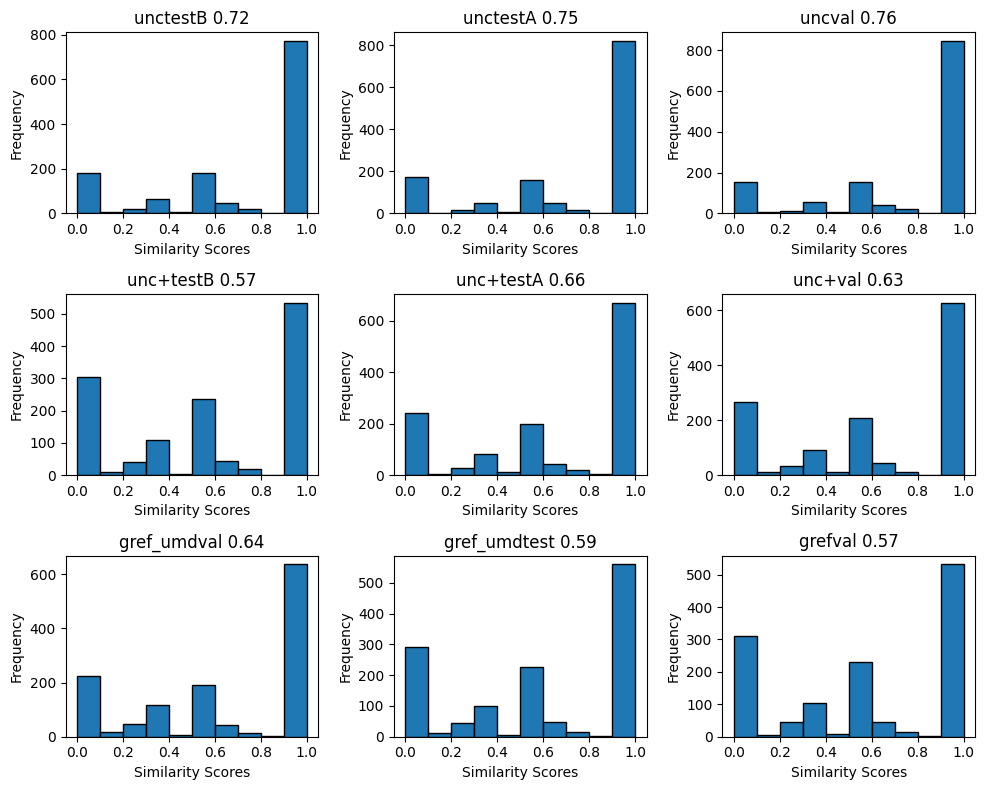

In [8]:

# Create a 3x3 grid of histograms
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
titles=title_sim
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the data and axes to create histograms
for i, ax in enumerate(axes):
    ax.hist(plot_list[i], bins=10, edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel("Similarity Scores")
    ax.set_ylabel('Frequency')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
